In [1]:
import re
import nltk
# to show progress bar
from tqdm import tqdm
# for pretty printing
import pprint
import spacy
import pandas as pd 
from itertools import chain
from collections import Counter
from nltk.corpus import stopwords
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))
nlp = spacy.load("es_core_news_sm")

# for topic modelling
from gensim import corpora
from gensim.models import ldamodel
from gensim.models import CoherenceModel

# for data viz
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns



##############################DataFrame################################
coments_x = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/twitter/coments_x.csv", usecols=["texto"])
coments_tiktok = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/tiktok/coments_tiktok.csv", usecols=["texto"])
coments_insta = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/insta/coments_insta.csv", usecols=["texto"])
coments_fb = pd.read_csv("/home/milton/Documentos/khorda_data/lomeli/facebook/coments_fb.csv", usecols=["texto"])

# Concatenar todos los dataframes

df_coments = pd.concat([coments_fb, coments_x, coments_tiktok, coments_insta], axis=0)
df_coments

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /home/milton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,texto
0,Bn día!! Regidor@s ✨
1,Gracias asu tolerancia Firmeza y transparencia...
2,Vamos apoyar con todo al Dr. Carlos Lomelí\nSI...
3,Saludos cordiales desde cocula jalisco México ...
4,Buenos días. q la ciudadanía despierte ya MC p...
...,...
20,jalisco tiene esperanza!!! gobernador 👏🏼👏🏼👏🏼👏...
21,hoy en el se llevó a cabo el donde estuviero...
22,"👉gracias a las asociaciones civiles , y a las..."
23,visita campamento mayto


In [2]:
def data_clean(df):
    """
    Parameters
    ----------
    df : DataFrame con columnas
            'texto','comentarisos'repost', 'likes','views'.
    Returns
    -------
    df_posts : DataFrame
        Retorna dos DataFrames limpios:
            El primero con las columnas 'coment','rt','like','views'.
            El segundo con las columnas 'texto', 'tokens'.
    """
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'\d', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[.,;!?]', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'jaja(ja)*', '', str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r"(, '[\W\.]')",r"", str(x)))
    df['texto'] = df['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    df = df.fillna('')
    return df

df_coments= data_clean(df_coments)
df_coments

,texto
0,bn día regidors
1,gracias asu tolerancia firmeza y transparencia...
2,vamos apoyar con todo al dr carlos lomelí\nsi ...
3,saludos cordiales desde cocula jalisco méxico ...
4,buenos días q la ciudadanía despierte ya mc pu...
...,...
20,jalisco tiene esperanza gobernador ayer toco...
21,hoy en el se llevó a cabo el donde estuviero...
22,gracias a las asociaciones civiles y a las b...
23,visita campamento mayto


In [9]:
nlp.disable_pipes('ner')
print(nlp.pipe_names)
dataset = df_coments['texto']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)
counts_word_occurence = Counter(chain(*[x for x in docs]))
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>1] for text in docs]  
docs_length=len(docs)
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>4}
docs =  [[lemma for lemma in text if counts_word_percentage[lemma]<4] for text in docs]


/home/milton/.local/lib/python3.10/site-packages/spacy/language.py:1067: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer']


100%|██████████████████████████████████████| 2886/2886 [00:09<00:00, 305.37it/s]


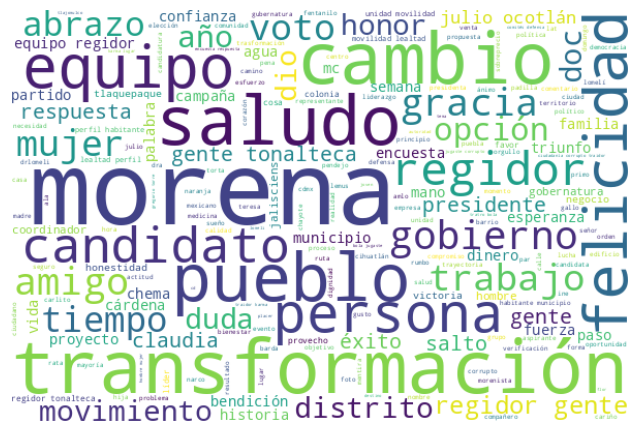

In [18]:
######Nube de Palabras########################
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Limpieza de Stop_words
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli","jajaja"
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast","vas","jajajaja","dio","par",
                "drcarloslomeli", "doc", "dr", "jajajajajajaja", "vez"))

docs = [word for word in docs if word not in stop_words]
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in docs for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)

# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Cículo
# Crear una máscara en blanco para establecer un fondo transparente

# Crear el objeto WordCloud
wordcloud = WordCloud(width=600, height=400, background_color="white").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(8, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.savefig("coments.png", dpi=200, bbox_inches="tight")
plt.show()

[[], ['tolerancia', 'firmeza', 'persona', 'sueño', 'pueblo', 'gracias'], [],
 ['saludo'], ['ciudadanía', 'robo'],
 ['unión', 'tvla', 'abrazo', 'actitud', 'voz'], ['tema'], [], ['favor', 'agua'],
 ['mc'], [], [], ['distrito'], [], ['lomeli', 'actitud'],
 ['voto', 'cambio', 'municipio'], [], [], [], [], [], ['salto'], [], ['equipo'],
 ['joven', 'señor', 'tranza', 'morena'], ['gobernatura', 'pueblo', 'voto'],
 ['visita', 'promesa', 'discurso'], ['distrito', 'cd', 'guzmán'], [],
 ['equipo'], ['equipo', 'transformación'], [], ['transformación', 'municipio'],
 [], ['gente', 'morena'], ['cambio', 'drcarlo'],
 ['pueblo', 'jalisciens', 'transformación', 'historia'], [],
 ['felicidad', 'hora', 'saludo', 'servidora'],
 ['coordinador', 'morena', 'doc', 'regidor', 'transformación'],
 ['familia', 'morena', 'salto'], ['hombre', 'palabra', 'naranja'], ['saludo'],
 ['felicidad'], ['placer', 'equipo'], ['apollo'], [], ['duda', 'opción'],
 ['doc'], ['saludo', 'señora', 'centro', 'salud', 'comunidad', 'be

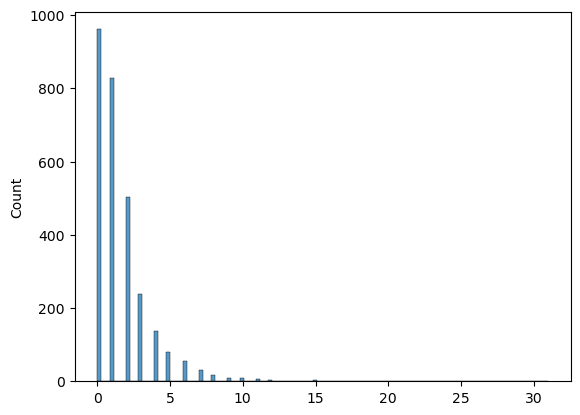

In [19]:
###############################################
pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs)
lengths =  [len(x) for x in docs]
sns.histplot(lengths)
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=26, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

scores = calculate_coherence(dictionary, corpus, docs, 10, 30)
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

In [21]:
###########Modelo LDA Topics##########################
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=17, alpha='auto', eval_every=5)

# print topics
lda_model.print_topics(-1)


# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

########################################
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(viz, 'ldavis_visualization.html')

(0, '0.048*"año" + 0.044*"transformación" + 0.043*"defensa" + 0.042*"municipio" + 0.035*"sheinbaum" + 0.035*"millón" + 0.035*"representante" + 0.033*"honor" + 0.032*"tiempo" + 0.028*"mujer"')
(1, '0.049*"distrito" + 0.049*"bola" + 0.041*"empresa" + 0.037*"dio" + 0.036*"regidor" + 0.033*"proceso" + 0.033*"tradición" + 0.029*"comentario" + 0.027*"mc" + 0.025*"base"')
(2, '0.082*"gente" + 0.055*"candidata" + 0.046*"pendejo" + 0.037*"comunidad" + 0.030*"vida" + 0.025*"jalisciens" + 0.024*"dinero" + 0.023*"hora" + 0.021*"regidor" + 0.019*"barrio"')
(3, '0.136*"mujer" + 0.090*"madre" + 0.052*"género" + 0.028*"imagen" + 0.028*"echo" + 0.027*"honor" + 0.026*"hombre" + 0.022*"unidad" + 0.020*"hija" + 0.020*"gracia"')
(4, '0.101*"barda" + 0.064*"pena" + 0.058*"doc" + 0.052*"evento" + 0.043*"pueblo" + 0.043*"ciudad" + 0.023*"desarrollo" + 0.021*"salto" + 0.018*"gente" + 0.017*"lugar"')
(5, '0.080*"candidato" + 0.057*"político" + 0.052*"corrupto" + 0.049*"narco" + 0.035*"amigo" + 0.033*"negocio" +

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

<class 'pyLDAvis._prepare.PreparedData'>


In [8]:
viz


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.136181  0.084889       1        1  9.496680
0     -0.088483  0.121932       2        1  7.761353
3      0.056694 -0.023071       3        1  7.680987
16     0.145597  0.016358       4        1  7.490438
1      0.084510 -0.062134       5        1  6.616460
4      0.016108  0.029633       6        1  6.181057
9      0.064664 -0.077894       7        1  6.003744
7     -0.131251 -0.010666       8        1  5.529609
6     -0.069081 -0.091499       9        1  5.405600
2     -0.145253  0.094640      10        1  5.385898
10    -0.010774  0.067098      11        1  5.053276
14    -0.164737 -0.144036      12        1  4.871234
12    -0.005912 -0.092649      13        1  4.830759
13    -0.018216  0.194150      14        1  4.809720
15    -0.052138 -0.082188      15        1  4.772934
11     0.045314  0.075989      16        1  4.356544
5      0.136776 -0.100552      17        1  3.753705, topic_info=               Term        Freq       Total Category  logprob  loglift
59        candidato   72.000000   72.000000  Default  30.0000  30.0000
87        respuesta   37.000000   37.000000  Default  29.0000  29.0000
26           morena  101.000000  101.000000  Default  28.0000  28.0000
314      comentario   27.000000   27.000000  Default  27.0000  27.0000
35   transformación   67.000000   67.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
86         encuesta    1.299789   32.749268  Topic17  -4.8903   0.0557
205            paso    1.021188   16.648452  Topic17  -5.1315   0.4911
18         distrito    1.070206   22.307229  Topic17  -5.0846   0.2454
64         gobierno    0.901463   31.131337  Topic17  -5.2562  -0.2595
69       movimiento    0.586009   23.792881  Topic17  -5.6869  -0.4214

[734 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
183       3  0.567866   aaaaa
9         2  0.163111  abrazo
9         4  0.163111  abrazo
9         6  0.108741  abrazo
9         7  0.380592  abrazo
...     ...       ...     ...
102       8  0.157044   éxito
102       9  0.078522   éxito
102      10  0.157044   éxito
102      16  0.078522   éxito
341      17  0.798354   órden

[1114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 4, 17, 2, 5, 10, 8, 7, 3, 11, 15, 13, 14, 16, 12, 6])